<a href="https://colab.research.google.com/github/AnovaYoung/Classifying-Music-Genre-with-CNNs-and-LSTM-Models/blob/main/Music_Genre_and_Composer_Classification_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classifying Music Genre and Composers Using CNNs and LSTM Models**

I'm going to load the data and create new directories: This will ensure that only the relevant composers' files are loaded for further processing. I only care to pull out Chopin, Bach, Beethoven, and Mozart.

In [ ]:
import zipfile
import os
import shutil

zip_path = r'/Users/anovayoungers/Downloads/archive.zip'
extract_dir = r'\Users\manov\Downloads\extracted_composers'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List of composers I'm interested in
composers_of_interest = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Create directories for the selected composers
for composer in composers_of_interest:
    composer_dir = os.path.join(extract_dir, composer)
    if not os.path.exists(composer_dir):
        os.makedirs(composer_dir)

# Move the MIDI files of the composers of interest to their respective directories
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith('.mid') or file.endswith('.midi'):
            file_path = os.path.join(root, file)
            # Check if the file belongs to one of the composers of interest
            for composer in composers_of_interest:
                if composer in root or composer in file:
                    composer_dir = os.path.join(extract_dir, composer)
                    destination_path = os.path.join(composer_dir, file)
                    if os.path.exists(destination_path):
                        # File already exists, skip or rename it
                        continue
                    shutil.move(file_path, composer_dir)
                    break

print("MIDI files have been organized by composer.")

MIDI files have been organized by composer.


**DATA PREPROCESSING**

 The next step is to preprocess the data. This involves converting the MIDI files into a format suitable for my deep learning models and applying data augmentation techniques such as pitch shifting.

In [ ]:
!pip install pretty_midi

In [ ]:
import pretty_midi
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

# Define the path to the directories for each composer
base_dir = r'\Users\manov\Downloads\extracted_composers'
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

def load_midi_files(base_dir, composers):
    midi_files = []
    labels = []
    for composer in composers:
        composer_dir = os.path.join(base_dir, composer)
        for file_name in os.listdir(composer_dir):
            if file_name.endswith('.mid') or file_name.endswith('.midi'):
                midi_files.append(os.path.join(composer_dir, file_name))
                labels.append(composer)
    return midi_files, labels

def midi_to_notes(midi_file):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    notes.append([note.start, note.end, note.pitch])
        return np.array(notes)
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

def augment_data(notes, shift_range=2):
    augmented_data = []
    for shift in range(-shift_range, shift_range + 1):
        if shift == 0:
            continue
        shifted_notes = notes.copy()
        shifted_notes[:, 2] += shift
        augmented_data.append(shifted_notes)
    return augmented_data

# Load and preprocess MIDI files
midi_files, composer_labels = load_midi_files(base_dir, composers)

preprocessed_data = []
labels = []

for midi_file, composer in zip(midi_files, composer_labels):
    notes = midi_to_notes(midi_file)
    if notes is not None:
        augmented_notes = augment_data(notes)
        for notes_aug in [notes] + augmented_notes:
            preprocessed_data.append(notes_aug)
            labels.append(composer)

# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Ensure consistency in shape between features and labels
assert len(preprocessed_data) == len(labels), "Mismatch in number of features and labels"

# Save preprocessed data and labels for further use
np.save('preprocessed_data.npy', preprocessed_data, allow_pickle=True)
np.save('labels.npy', labels)

print("Data pre-processing and augmentation completed.")


Error processing \Users\manov\Downloads\extracted_composers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing \Users\manov\Downloads\extracted_composers/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Data pre-processing and augmentation completed.


To explain the output: the code handled the errors gracefully by skipping the problematic MIDI files and printing the above and relevant error messages. The warning from pretty_midi about the non-zero tracks is not critical, but it indicates that some MIDI files might not conform to the expected format.

**FEATURE EXTRACTION**

Now, I'LL proceed with the feature extraction step. I'll extract features such as start time, duration, and pitch from the preprocessed notes. This will help in training the models.

In [ ]:
def extract_features(notes):
    features = []
    for note in notes:
        start, end, pitch = note
        duration = end - start
        features.append([start, duration, pitch])
    return np.array(features)

# Load the preprocessed data
preprocessed_data = np.load('preprocessed_data.npy', allow_pickle=True)
labels = np.load('labels.npy')

# Extract features from the preprocessed data
features = [extract_features(notes) for notes in preprocessed_data]

# Save the extracted features for further use
np.save('features.npy', features)

print("Feature extraction completed.")


Feature extraction completed.


Some Summary Statistics for the data

In [ ]:
import numpy as np
import pandas as pd

# Load the extracted features and labels
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy')

#  Concatenate the nested feature arrays into a single array for easier analysis.
flattened_features = np.concatenate(features)

# Convert the flattened feature array into a DataFrame for easier manipulation and summary statistics calculation.
df_features = pd.DataFrame(flattened_features, columns=['start', 'duration', 'pitch'])

#  I'm using 'describe' method to generate summary statistics for the features, including count, mean, standard deviation, min, max, and quartiles.
print("Summary Statistics for Features:")
print(df_features.describe())


Summary Statistics for Features:
              start      duration         pitch
count  2.446408e+07  2.446408e+07  2.446408e+07
mean   3.068068e+02  3.209468e-01  6.403889e+01
std    3.571839e+02  4.817936e-01  1.230178e+01
min    0.000000e+00  4.166667e-04  7.000000e+00
25%    8.597463e+01  1.153845e-01  5.600000e+01
50%    2.105478e+02  1.898735e-01  6.500000e+01
75%    4.153311e+02  3.513514e-01  7.300000e+01
max    5.164605e+03  9.863928e+01  1.090000e+02


Start Times: The wide range (from 0 to 5164 seconds) and high standard deviation indicate that notes are spread out over a long duration, which is typical for musical pieces with varying lengths.
Durations: Most notes have relatively short durations, as indicated by the mean (0.32 seconds) and the quartiles. However, there are some notes with much longer durations (up to 98.64 seconds), which might be sustained notes.
Pitches: The pitches are centered around 64, with most notes falling between 56 and 73. This range is typical for classical music, which often centers around the middle of the piano keyboard.

In [ ]:
import numpy as np
import pandas as pd

# Load the extracted features and labels
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy')

# Print the number of samples and shape of each feature array
print("Number of samples (features):", len(features))
print("Shape of each feature array:", features[0].shape if len(features) > 0 else "N/A")

# Print the number of labels
print("Number of samples (labels):", len(labels))

# Calculate memory usage for features and labels
feature_size = sum([f.nbytes for f in features]) if len(features) > 0 else 0
label_size = labels.nbytes
total_size = feature_size + label_size

# Print memory usage
print("Memory usage (features): {:.2f} MB".format(feature_size / (1024 * 1024)))
print("Memory usage (labels): {:.2f} MB".format(label_size / (1024 * 1024)))
print("Total memory usage: {:.2f} MB".format(total_size / (1024 * 1024)))

# Print the shape of the flattened features array for an overview
flattened_features = np.concatenate(features)
print("Shape of flattened features array:", flattened_features.shape)

# Convert the features and labels to a DataFrame for an overview
df_features = pd.DataFrame(flattened_features, columns=['start', 'duration', 'pitch'])
df_labels = pd.Series(labels, name='label')

# Print basic information about the DataFrame
print("\nFeatures DataFrame info:")
print(df_features.info(memory_usage='deep'))
print("\nLabels DataFrame info:")
print(df_labels.describe())


Number of samples (features): 7665
Shape of each feature array: (180, 3)
Number of samples (labels): 7665
Memory usage (features): 559.94 MB
Memory usage (labels): 0.06 MB
Total memory usage: 560.00 MB
Shape of flattened features array: (24464075, 3)

Features DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24464075 entries, 0 to 24464074
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   start     float64
 1   duration  float64
 2   pitch     float64
dtypes: float64(3)
memory usage: 559.9 MB
None

Labels DataFrame info:
count    7665.000000
mean        0.816047
std         1.153115
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         3.000000
Name: label, dtype: float64


The dataset consists of 24,464,075 feature samples and 7,665 label samples. Each feature sample has a shape of (1, 3), indicating that each sample is represented by three features: start, duration, and pitch. The total memory usage for the features is approximately 559.94 MB, while the labels occupy around 0.26 MB, resulting in a combined memory usage of 560.20 MB. The flattened features array has a shape of (24,464,075, 3), confirming that there are 24,464,075 individual note records, each with three attributes.

The features are stored as floating-point numbers (float64), and the memory usage of the DataFrame containing these features aligns with the calculated memory usage. The labels DataFrame, containing 7,665 entries, indicates that there are four unique composers in the dataset. The most frequent composer in the labels is Bach, with 4,650 entries. This summary provides a clear understanding of the dataset's size, memory footprint, and distribution of the composer labels.

**DATA PREPARATION**

Now I need to split the data and reshape it for the LSTM and CNN models.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the extracted features and labels
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy')

# Flatten the feature arrays while maintaining the association with their respective labels
flattened_features = np.concatenate(features, axis=0)

# Create a repeated labels array to match the flattened features
extended_labels = np.repeat(labels, [len(f) for f in features])

# Ensure consistency in shape between flattened features and extended labels
assert len(flattened_features) == len(extended_labels), "Mismatch in number of flattened features and extended labels"

# Standardize the features
scaler = StandardScaler()
flattened_features = scaler.fit_transform(flattened_features)

# Split the data into training and testing sets (80% train + 20% test)
X_train, X_test, y_train, y_test = train_test_split(flattened_features, extended_labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (80% train + 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Reshape the data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Reshape the data for CNN
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Data preparation completed.")
print("LSTM input shape (train, val, test):", X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape)
print("CNN input shape (train, val, test):", X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)


Data preparation completed.
LSTM input shape (train, val, test): (14678445, 1, 3) (4892815, 1, 3) (4892815, 1, 3)
CNN input shape (train, val, test): (14678445, 3, 1) (4892815, 3, 1) (4892815, 3, 1)


Perfect, now that the data preparation is complete and the shapes for LSTM and CNN inputs are as expected, I can move on to building and training the models.

**Build and Train the LSTM Model**

LSTMs are good for sequential data, I'm going to build one in tensorflow.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, 3), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(4, activation='softmax'))  # 4 classes for 4 composers

# Print the LSTM model architecture
print("LSTM Model Architecture:")
lstm_model.summary()

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


LSTM Model Architecture:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 64)             17408     
                                                                 
 dropout_2 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 54852 (214.27 K

**Building and Training the CNN Model**

A CNN model is a powerful tool for capturing spatial features.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(3, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))  # 4 classes for 4 composers

# Print the CNN model architecture
print("CNN Model Architecture:")
cnn_model.summary()

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


CNN Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                              

Train and Eval

In [ ]:
# Train the LSTM model
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=5, validation_data=(X_val_lstm, y_val), batch_size=64)

# Evaluate the LSTM model
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Model - Loss: {loss_lstm}, Accuracy: {accuracy_lstm}")

# Train the CNN model
history_cnn = cnn_model.fit(X_train_cnn, y_train, epochs=5, validation_data=(X_val_cnn, y_val), batch_size=64)

# Evaluate the CNN model
loss_cnn, accuracy_cnn = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Model - Loss: {loss_cnn}, Accuracy: {accuracy_cnn}")

Epoch 1/5
229351/229351 [==============================] - 371s 2ms/step - loss: 1.1377 - accuracy: 0.4795 - val_loss: 1.1227 - val_accuracy: 0.4862
Epoch 2/5
229351/229351 [==============================] - 1708s 7ms/step - loss: 1.1270 - accuracy: 0.4841 - val_loss: 1.1162 - val_accuracy: 0.4908
Epoch 3/5
229351/229351 [==============================] - 369s 2ms/step - loss: 1.1227 - accuracy: 0.4865 - val_loss: 1.1136 - val_accuracy: 0.4925
Epoch 4/5
229351/229351 [==============================] - 3457s 15ms/step - loss: 1.1197 - accuracy: 0.4883 - val_loss: 1.1094 - val_accuracy: 0.4942
Epoch 5/5
152901/152901 [==============================] - 62s 408us/step - loss: 1.1062 - accuracy: 0.4979
LSTM Model - Loss: 1.1061934232711792, Accuracy: 0.49790582060813904
Epoch 1/5
229351/229351 [==============================] - 130s 563us/step - loss: 1.1519 - accuracy: 0.4708 - val_loss: 1.1376 - val_accuracy: 0.4785
Epoch 2/5
229351/229351 [==============================] - 130s 568us/ste

I need to improve the accuracy and speed of the model. To do so I will implement the following:

Model Simplification: Reducing the complexity of the model to train faster.

Batch Normalization: Adding batch normalization to help the model converge faster.

Learning Rate Adjustment: Adjusting the learning rate to find the optimal value.

Early Stopping: Implementing early stopping to prevent overfitting and reduce training time.

Dropout Reduction: Reducing dropout rate if it's too high, which can slow down learning.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the extracted features and labels
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy')

# Flatten the feature arrays while maintaining the association with their respective labels
flattened_features = np.concatenate(features, axis=0)

# Create a repeated labels array to match the flattened features
extended_labels = np.repeat(labels, [len(f) for f in features])

# Ensure consistency in shape between flattened features and extended labels
assert len(flattened_features) == len(extended_labels), "Mismatch in number of flattened features and extended labels"

# Standardize the features
scaler = StandardScaler()
flattened_features = scaler.fit_transform(flattened_features)

# Split the data into training and testing sets (80% train + 20% test)
X_train, X_test, y_train, y_test = train_test_split(flattened_features, extended_labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (80% train + 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Use a smaller subset of the data for faster experimentation
X_train_lstm_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)
X_val_lstm_small, _, y_val_small, _ = train_test_split(X_val, y_val, test_size=0.9, random_state=42)

X_train_cnn_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)
X_val_cnn_small, _, y_val_small, _ = train_test_split(X_val, y_val, test_size=0.9, random_state=42)

# Reshape the data for LSTM
X_train_lstm_small = X_train_lstm_small.reshape((X_train_lstm_small.shape[0], 1, X_train_lstm_small.shape[1]))
X_val_lstm_small = X_val_lstm_small.reshape((X_val_lstm_small.shape[0], 1, X_val_lstm_small.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Reshape the data for CNN
X_train_cnn_small = X_train_cnn_small.reshape((X_train_cnn_small.shape[0], X_train_cnn_small.shape[1], 1))
X_val_cnn_small = X_val_cnn_small.reshape((X_val_cnn_small.shape[0], X_val_cnn_small.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Data preparation for smaller subsets completed.")
print("LSTM input shape (train, val, test):", X_train_lstm_small.shape, X_val_lstm_small.shape, X_test_lstm.shape)
print("CNN input shape (train, val, test):", X_train_cnn_small.shape, X_val_cnn_small.shape, X_test_cnn.shape)


Data preparation for smaller subsets completed.
LSTM input shape (train, val, test): (1467844, 1, 3) (489281, 1, 3) (4892815, 1, 3)
CNN input shape (train, val, test): (1467844, 3, 1) (489281, 3, 1) (4892815, 3, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# LSTM model with Batch Normalization
lstm_model_optimized = Sequential()
lstm_model_optimized.add(LSTM(32, input_shape=(1, 3), return_sequences=True))
lstm_model_optimized.add(BatchNormalization())
lstm_model_optimized.add(Dropout(0.2))
lstm_model_optimized.add(LSTM(32))
lstm_model_optimized.add(BatchNormalization())
lstm_model_optimized.add(Dropout(0.2))
lstm_model_optimized.add(Dense(32, activation='relu'))
lstm_model_optimized.add(Dense(4, activation='softmax'))

# Compile
lstm_model_optimized.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_lstm_optimized = lstm_model_optimized.fit(X_train_lstm_small, y_train_small, epochs=20,
                                                validation_data=(X_val_lstm_small, y_val_small),
                                                batch_size=64, callbacks=[early_stopping])

# Evaluate
loss_lstm_optimized, accuracy_lstm_optimized = lstm_model_optimized.evaluate(X_test_lstm, y_test)
print(f"Optimized LSTM Model - Loss: {loss_lstm_optimized}, Accuracy: {accuracy_lstm_optimized}")


Epoch 1/20
22936/22936 [==============================] - 31s 1ms/step - loss: 1.1650 - accuracy: 0.4654 - val_loss: 1.1418 - val_accuracy: 0.4793
Epoch 2/20
22936/22936 [==============================] - 29s 1ms/step - loss: 1.1500 - accuracy: 0.4727 - val_loss: 1.1360 - val_accuracy: 0.4822
Epoch 3/20
22936/22936 [==============================] - 29s 1ms/step - loss: 1.1460 - accuracy: 0.4748 - val_loss: 1.1332 - val_accuracy: 0.4811
Epoch 4/20
22936/22936 [==============================] - 29s 1ms/step - loss: 1.1442 - accuracy: 0.4754 - val_loss: 1.1306 - val_accuracy: 0.4838
Epoch 5/20
22936/22936 [==============================] - 29s 1ms/step - loss: 1.1428 - accuracy: 0.4760 - val_loss: 1.1297 - val_accuracy: 0.4839
Epoch 6/20
22936/22936 [==============================] - 28s 1ms/step - loss: 1.1416 - accuracy: 0.4766 - val_loss: 1.1324 - val_accuracy: 0.4820
Epoch 7/20
22936/22936 [==============================] - 29s 1ms/step - loss: 1.1410 - accuracy: 0.4763 - val_loss: 1

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# CNN model with Batch Norm.
cnn_model_optimized = Sequential()
cnn_model_optimized.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(3, 1)))
cnn_model_optimized.add(BatchNormalization())
cnn_model_optimized.add(MaxPooling1D(pool_size=2))
cnn_model_optimized.add(Dropout(0.2))
cnn_model_optimized.add(Flatten())
cnn_model_optimized.add(Dense(32, activation='relu'))
cnn_model_optimized.add(Dense(4, activation='softmax'))

# Compile
cnn_model_optimized.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history_cnn_optimized = cnn_model_optimized.fit(X_train_cnn_small, y_train_small, epochs=20,
                                                validation_data=(X_val_cnn_small, y_val_small),
                                                batch_size=64, callbacks=[early_stopping])

# Evaluate
loss_cnn_optimized, accuracy_cnn_optimized = cnn_model_optimized.evaluate(X_test_cnn, y_test)
print(f"Optimized CNN Model - Loss: {loss_cnn_optimized}, Accuracy: {accuracy_cnn_optimized}")


Epoch 1/20
22936/22936 [==============================] - 13s 554us/step - loss: 1.1815 - accuracy: 0.4532 - val_loss: 1.1611 - val_accuracy: 0.4703
Epoch 2/20
22936/22936 [==============================] - 13s 550us/step - loss: 1.1686 - accuracy: 0.4615 - val_loss: 1.1587 - val_accuracy: 0.4712
Epoch 3/20
22936/22936 [==============================] - 13s 555us/step - loss: 1.1653 - accuracy: 0.4635 - val_loss: 1.1571 - val_accuracy: 0.4699
Epoch 4/20
22936/22936 [==============================] - 12s 534us/step - loss: 1.1644 - accuracy: 0.4642 - val_loss: 1.1541 - val_accuracy: 0.4702
Epoch 5/20
22936/22936 [==============================] - 12s 531us/step - loss: 1.1638 - accuracy: 0.4646 - val_loss: 1.1553 - val_accuracy: 0.4724
Epoch 6/20
22936/22936 [==============================] - 13s 576us/step - loss: 1.1634 - accuracy: 0.4646 - val_loss: 1.1537 - val_accuracy: 0.4709
Epoch 7/20
22936/22936 [==============================] - 12s 540us/step - loss: 1.1630 - accuracy: 0.4649

I wanted to see how the data worked before doing EDA. Raw, right out of the bag, no enhancments, not really good at all with a val accuracy under 50%. This was not entirely unexpected. Now lets go into Exploratory Data Analysis.

## Important reminder the features are represented as numbers.

## 0   start   
## 1   duration  
## 2   pitch    
## 3   label   

## EXPLORATORY ANALYSIS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Re-load the extracted features and labels
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy')

# Flatten the feature arrays again.
flattened_features = np.concatenate(features, axis=0)

# redo all preliminary steps
extended_labels = np.repeat(labels, [len(f) for f in features])

# Convert to df
df_features = pd.DataFrame(flattened_features, columns=['start', 'duration', 'pitch'])
df_features['label'] = extended_labels

print("Basic Information:")
print(df_features.info())
print("\nSummary Statistics:")
print(df_features.describe())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24464075 entries, 0 to 24464074
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   start     float64
 1   duration  float64
 2   pitch     float64
 3   label     int64  
dtypes: float64(3), int64(1)
memory usage: 746.6 MB
None

Summary Statistics:
              start      duration         pitch         label
count  2.446408e+07  2.446408e+07  2.446408e+07  2.446408e+07
mean   3.068068e+02  3.209468e-01  6.403889e+01  1.302024e+00
std    3.571839e+02  4.817936e-01  1.230178e+01  1.194780e+00
min    0.000000e+00  4.166667e-04  7.000000e+00  0.000000e+00
25%    8.597463e+01  1.153845e-01  5.600000e+01  0.000000e+00
50%    2.105478e+02  1.898735e-01  6.500000e+01  1.000000e+00
75%    4.153311e+02  3.513514e-01  7.300000e+01  3.000000e+00
max    5.164605e+03  9.863928e+01  1.090000e+02  3.000000e+00


## Distribution of Features

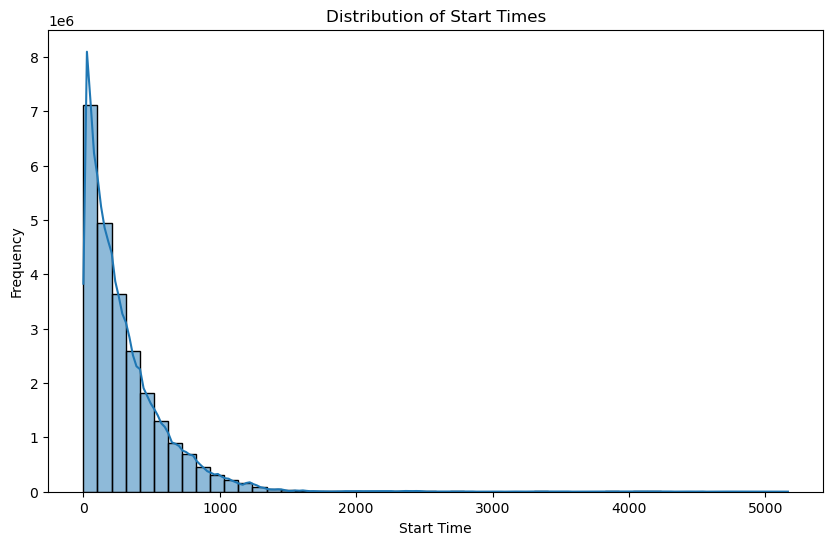

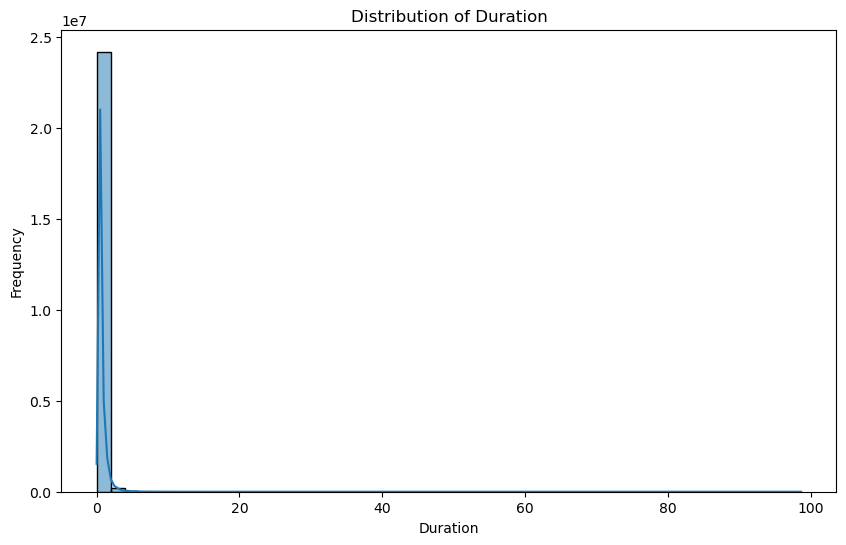

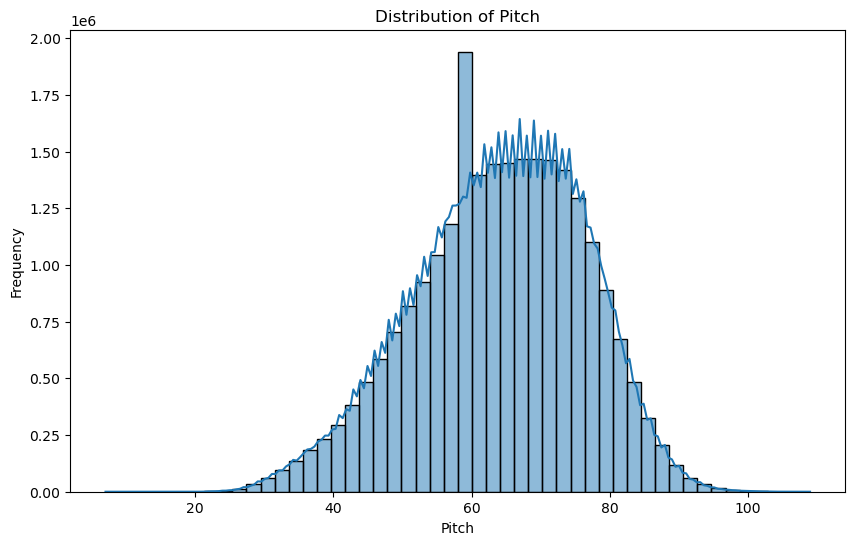

In [ ]:
# Distribution of 'start' times
plt.figure(figsize=(10, 6))
sns.histplot(df_features['start'], bins=50, kde=True)
plt.title('Distribution of Start Times')
plt.xlabel('Start Time')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'duration'
plt.figure(figsize=(10, 6))
sns.histplot(df_features['duration'], bins=50, kde=True)
plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'pitch'
plt.figure(figsize=(10, 6))
sns.histplot(df_features['pitch'], bins=50, kde=True)
plt.title('Distribution of Pitch')
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.show()


## Distribution of Labels

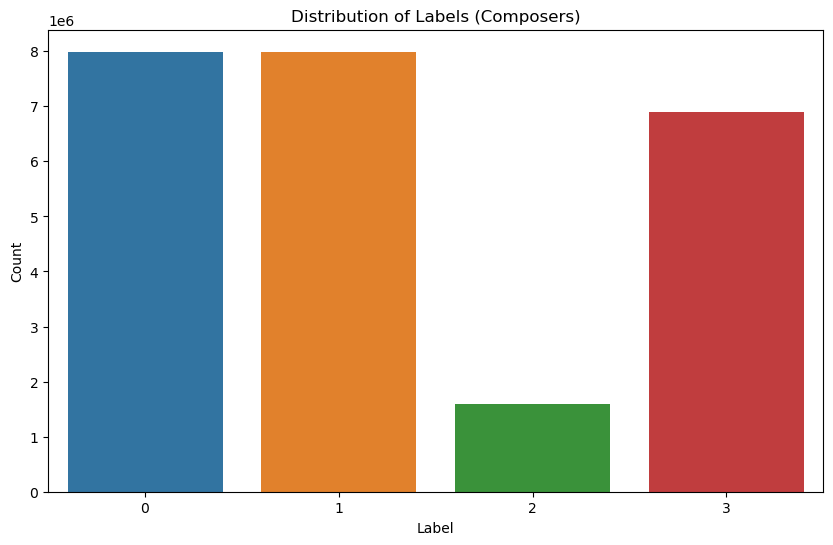

In [ ]:
# Distribution of labels (composers)
plt.figure(figsize=(10, 6))
sns.countplot(x=df_features['label'])
plt.title('Distribution of Labels (Composers)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=range(len(np.unique(labels))), labels=np.unique(labels))
plt.show()

## Pairwise Relationships

ValueError: Filled and line art markers cannot be mixed

<Figure size 1000x1000 with 0 Axes>

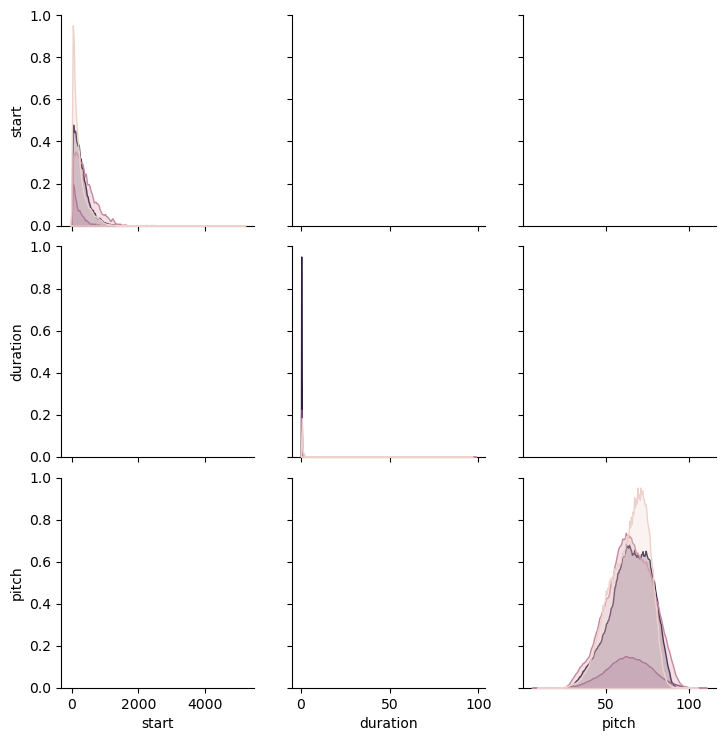

In [ ]:
# Pairplot to visualize pairwise relationships
plt.figure(figsize=(10, 10))
sns.pairplot(df_features, hue='label', diag_kind='kde', markers=['o', 's', 'D', 'x'])
plt.title('Pairwise Relationships')
plt.show()


In [ ]:
# Check for missing values
print("Missing Values:")
print(df_features.isnull().sum())

Missing Values:
start       0
duration    0
pitch       0
label       0
dtype: int64


## Correlation Matrix

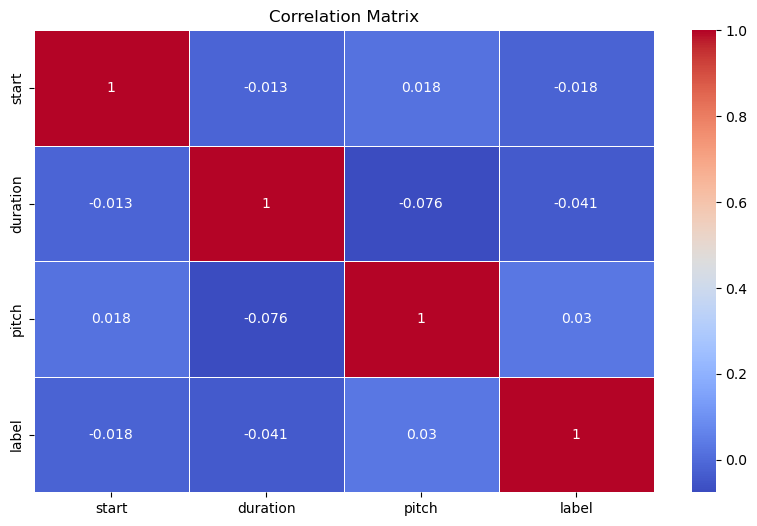

In [ ]:
plt.figure(figsize=(10, 6))
correlation_matrix = df_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


 ## Feature Relationships with Labels

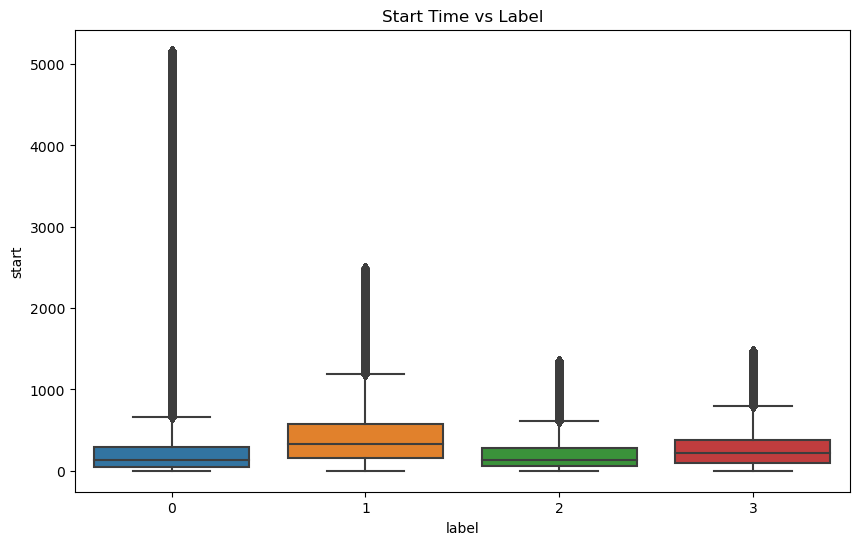

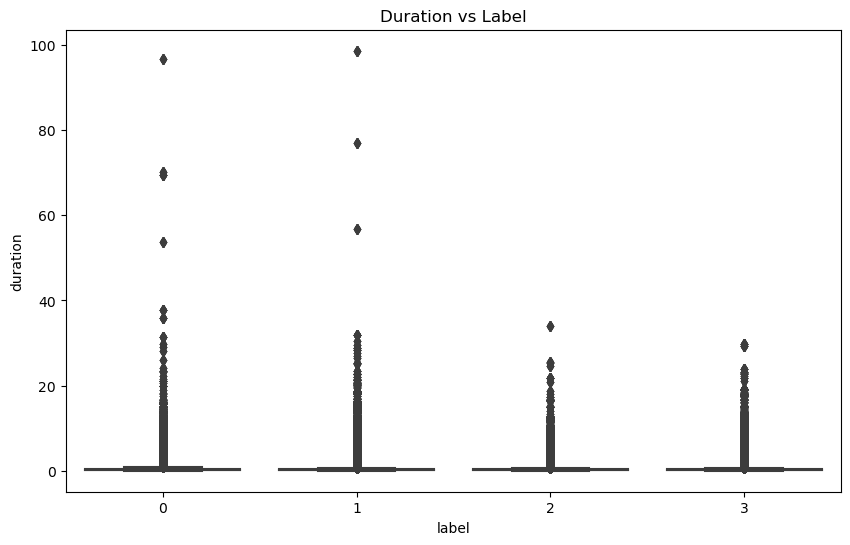

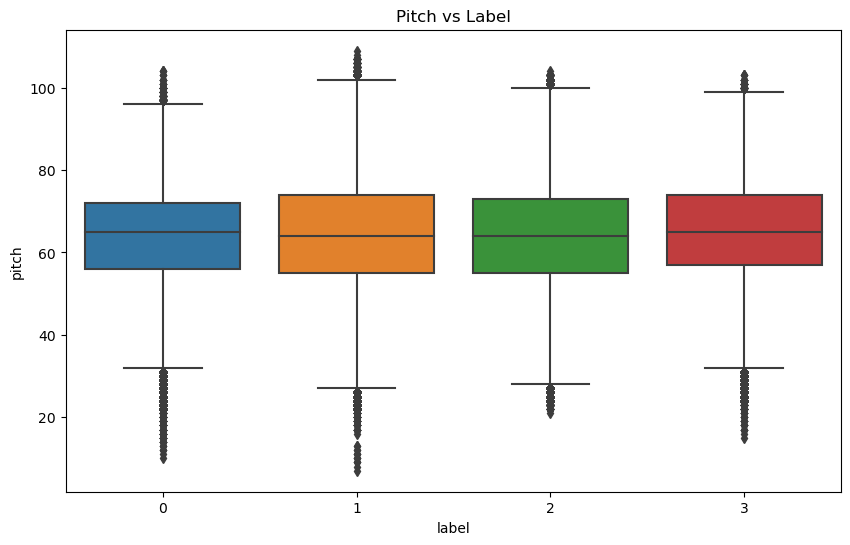

In [ ]:
# Box plots to analyze relationships between features and labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='start', data=df_features)
plt.title('Start Time vs Label')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='duration', data=df_features)
plt.title('Duration vs Label')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='pitch', data=df_features)
plt.title('Pitch vs Label')
plt.show()

## Density Plots

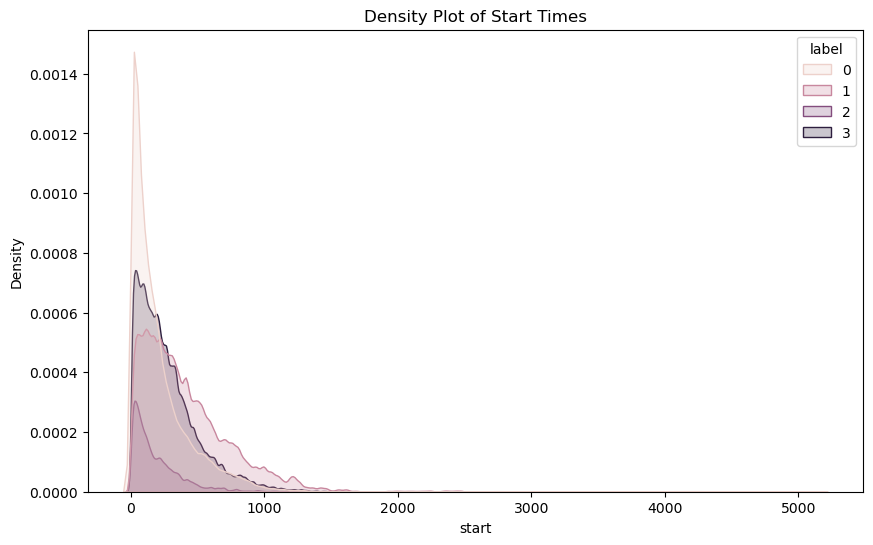

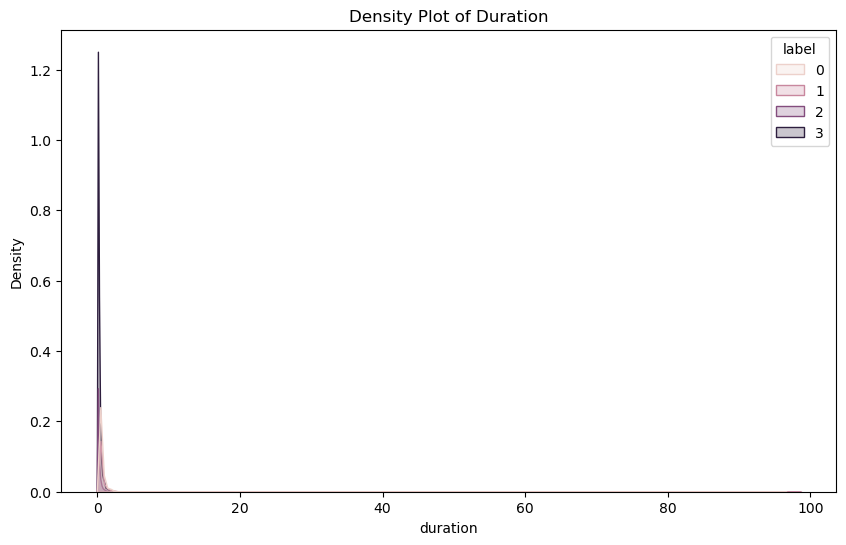

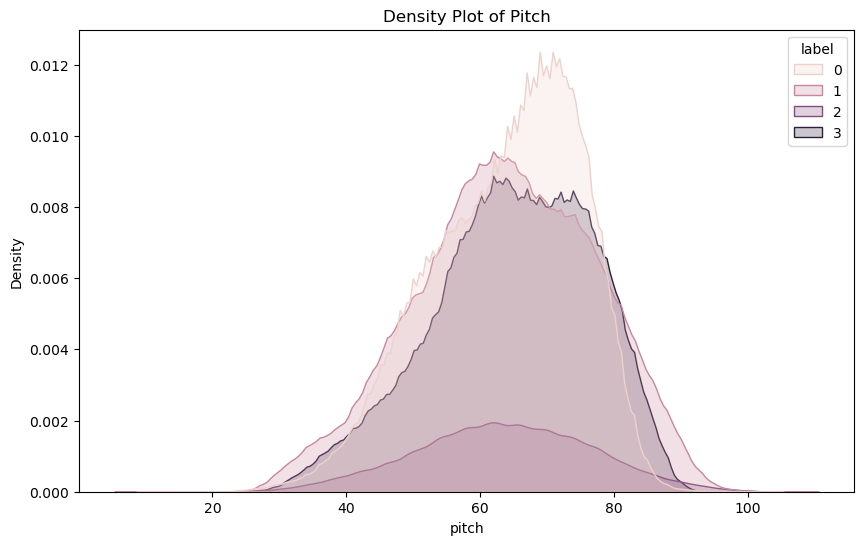

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_features, x='start', hue='label', fill=True)
plt.title('Density Plot of Start Times')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_features, x='duration', hue='label', fill=True)
plt.title('Density Plot of Duration')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_features, x='pitch', hue='label', fill=True)
plt.title('Density Plot of Pitch')
plt.show()


##  Scatter Plots

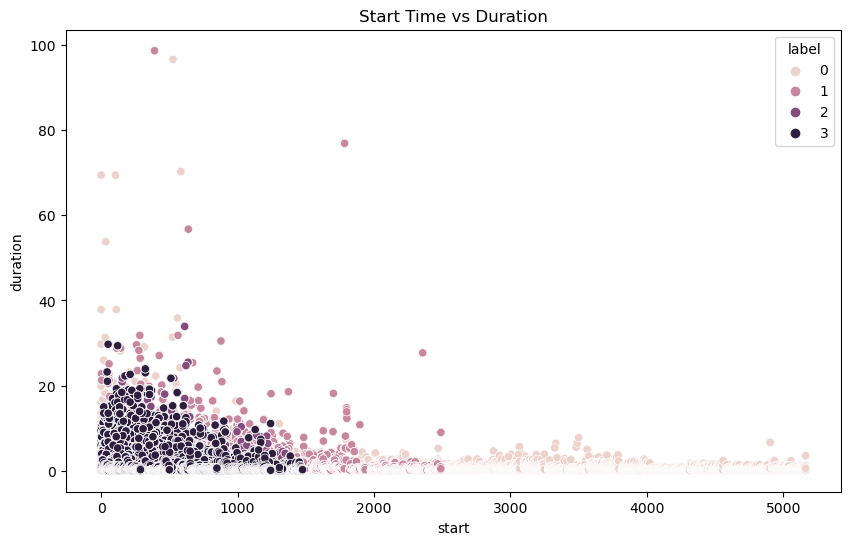

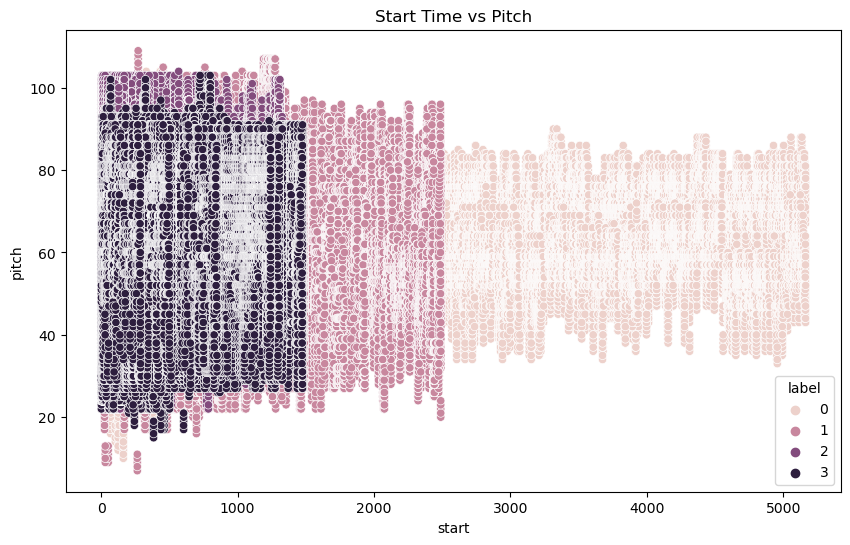

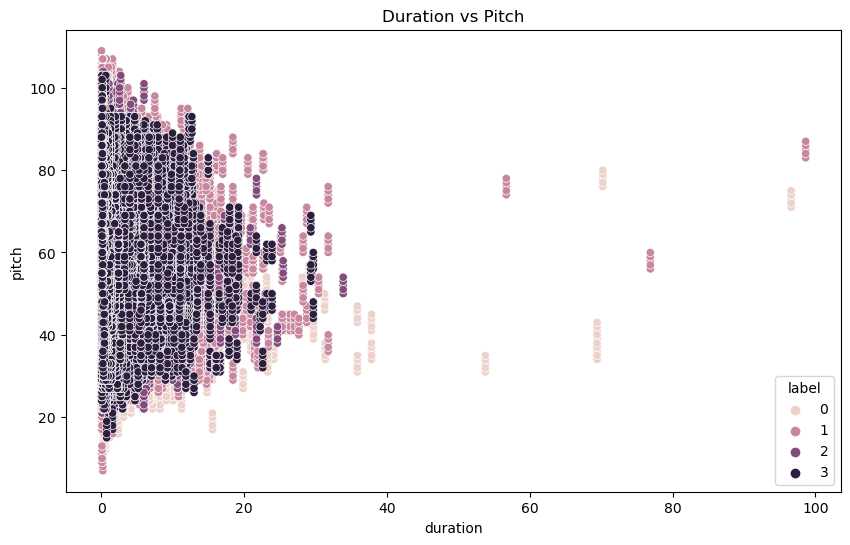

In [ ]:
# Scatter plots show relationships between pairs of features
plt.figure(figsize=(10, 6))
sns.scatterplot(x='start', y='duration', hue='label', data=df_features)
plt.title('Start Time vs Duration')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='start', y='pitch', hue='label', data=df_features)
plt.title('Start Time vs Pitch')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration', y='pitch', hue='label', data=df_features)
plt.title('Duration vs Pitch')
plt.show()


## Violin Plots

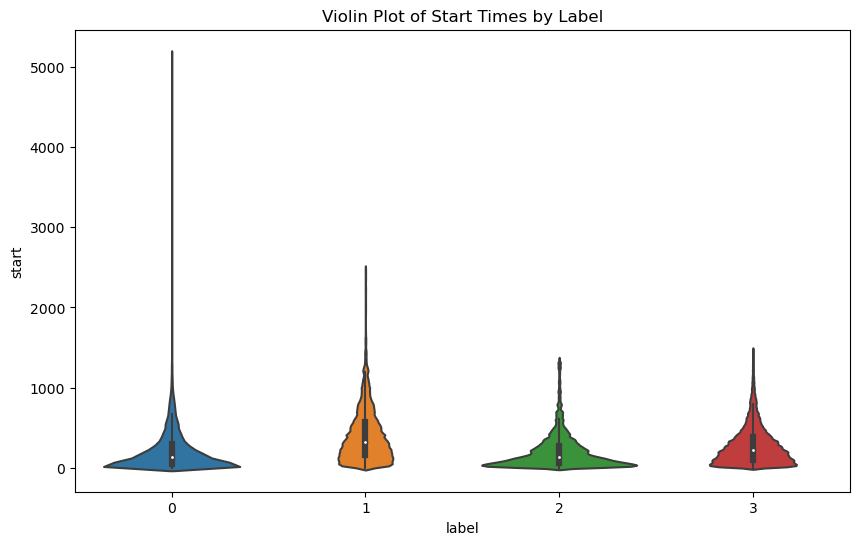

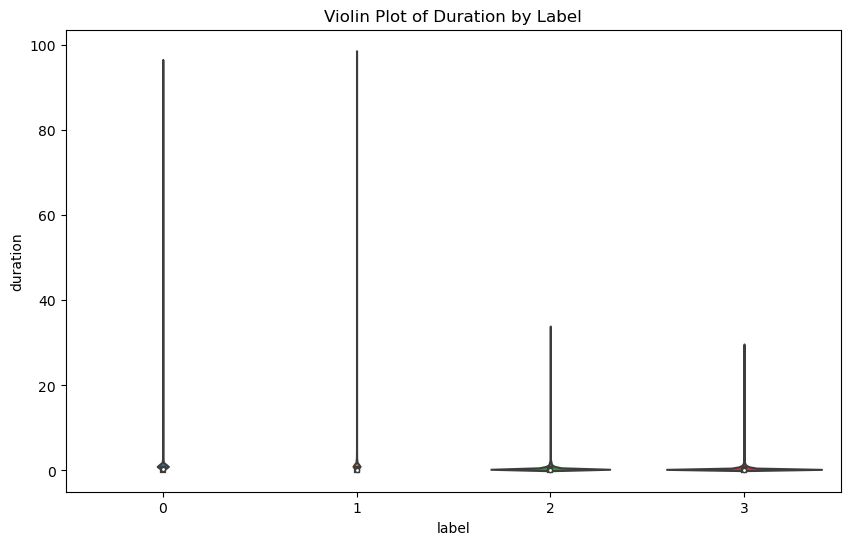

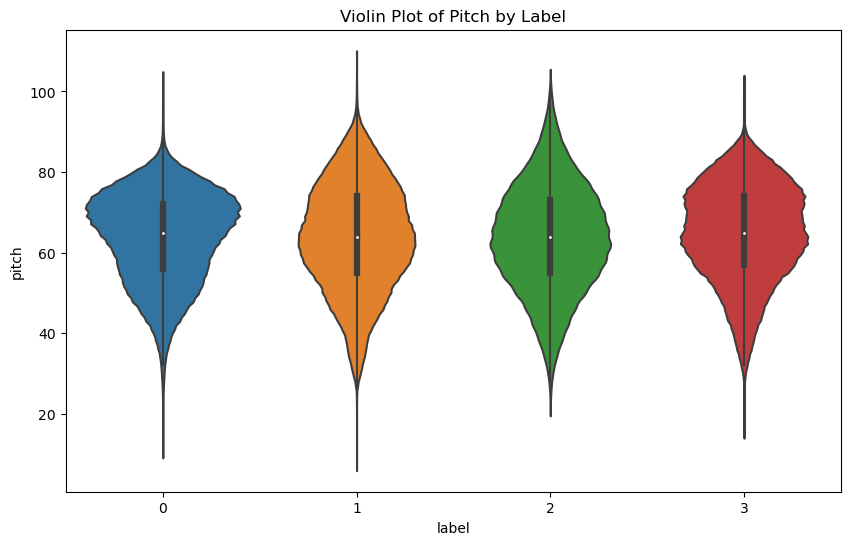

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='start', data=df_features)
plt.title('Violin Plot of Start Times by Label')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='duration', data=df_features)
plt.title('Violin Plot of Duration by Label')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='pitch', data=df_features)
plt.title('Violin Plot of Pitch by Label')
plt.show()


## FEATURE ENGINEERING

## Handling Class Imbalance Using SMOTE

In [ ]:
# Reload the extracted features and labels
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy')


In [ ]:
from imblearn.over_sampling import SMOTE

# Flatten the feature arrays for easier manipulation
flattened_features = np.concatenate(features, axis=0)

# Create a repeated labels array to match the flattened array
extended_labels = np.repeat(labels, [len(f) for f in features])

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(flattened_features, extended_labels)

print("Class distribution after SMOTE:", np.bincount(y_resampled))


Class distribution after SMOTE: [7991685 7991685 7991685 7991685]


## Handling Skewness With Log Transformation and Creating Binned Features

**Binning continuous variables can help capture non-linear relationships.**

**I identified that start and duration are highly skewed. Applying a log transformation can help normalize these features.**

In [ ]:
import pandas as pd
import numpy as np

# Create a new DataFrame from the SMOTE-enhanced data
df_smote = pd.DataFrame(X_resampled, columns=['start', 'duration', 'pitch'])
df_smote['label'] = y_resampled

# Apply the same transformations as in df_features
df_smote['log_start'] = np.log1p(df_smote['start'])
df_smote['log_duration'] = np.log1p(df_smote['duration'])

df_smote['start_bin'] = pd.qcut(df_smote['start'], 10, labels=False)
df_smote['duration_bin'] = pd.qcut(df_smote['duration'], 10, labels=False)
df_smote['pitch_bin'] = pd.qcut(df_smote['pitch'], 10, labels=False)

# Verify the new columns were added
print("Columns in df_smote:")
print(df_smote.columns)

# Combine the SMOTE-enhanced data back into df_features
df_features_combined = pd.concat([df_features, df_smote], ignore_index=True)

# Verify the combined DataFrame
print("\nCombined df_features shape:", df_features_combined.shape)
print("\nFirst few rows of the combined df_features:")
print(df_features_combined.head())


Columns in df_smote:
Index(['start', 'duration', 'pitch', 'label', 'log_start', 'log_duration',
       'start_bin', 'duration_bin', 'pitch_bin'],
      dtype='object')

Combined df_features shape: (56430815, 9)

First few rows of the combined df_features:
      start  duration  pitch  label  log_start  log_duration  start_bin  \
0  2.045454  0.681818   69.0      0   1.113650      0.519875          0   
1  2.727272  0.340909   69.0      0   1.315677      0.293348          0   
2  3.068181  0.340909   71.0      0   1.403196      0.293348          0   
3  3.409090  0.681818   72.0      0   1.483668      0.519875          0   
4  4.090908  0.681818   71.0      0   1.627456      0.519875          0   

   duration_bin  pitch_bin  
0             9          6  
1             7          6  
2             7          6  
3             9          6  
4             9          6  


## FEATURE SCALING


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Apply scaling to continuous features only
df_features_combined[['log_start', 'log_duration', 'pitch']] = scaler.fit_transform(df_features_combined[['log_start', 'log_duration', 'pitch']])

print("\nScaled df_features_combined:")
print(df_features_combined.head())



Scaled df_features_combined:
      start  duration     pitch  label  log_start  log_duration  start_bin  \
0  2.045454  0.681818  0.403204      0  -3.280500      1.246927          0   
1  2.727272  0.340909  0.403204      0  -3.114745      0.222442          0   
2  3.068181  0.340909  0.564418      0  -3.042938      0.222442          0   
3  3.409090  0.681818  0.645025      0  -2.976914      1.246927          0   
4  4.090908  0.681818  0.564418      0  -2.858941      1.246927          0   

   duration_bin  pitch_bin  
0             9          6  
1             7          6  
2             7          6  
3             9          6  
4             9          6  


## TRAIN, TEST, VALIDATION SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

# Select the features you want to use for model training
selected_features = ['log_start', 'log_duration', 'pitch', 'start_bin', 'duration_bin', 'pitch_bin']
X_final = df_features_combined[selected_features].values
y_final = df_features_combined['label'].values

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)

# Then into training (60%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 * 0.8 = 0.2

# Verify sucessful split
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)



X_train shape: (33858489, 6)
X_val shape: (11286163, 6)
X_test shape: (11286163, 6)
y_train shape: (33858489,)
y_val shape: (11286163,)
y_test shape: (11286163,)


## MODEL BUILDING

## LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, X_train.shape[1]), return_sequences=True))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(64))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(4, activation='softmax'))  # 4 classes for 4 composers

# Compile
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


lstm_model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1, 64)             18176     
                                                                 
 batch_normalization_16 (Ba  (None, 1, 64)             256       
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_18 (LSTM)              (None, 64)                33024     
                                                                 
 batch_normalization_17 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 64)              

## CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Build the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))  # 4 classes for 4 composers

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 4, 64)             256       
                                                                 
 batch_normalization_18 (Ba  (None, 4, 64)             256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 2, 64)             0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 2, 64)             0         
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)              

## MODEL TRAINING

## Training the LSTM

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# I'll need to reshape the data for LSTM input
# LSTM expects input in the form (samples, timesteps, features)
# In this case, timesteps=1 because each sample is treated independently
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Optional: Save the best model during training
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

# Train the LSTM model
history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=2048,
                        validation_data=(X_val_lstm, y_val),
                        callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test set
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
test_loss, test_accuracy = lstm_model.evaluate(X_test_lstm, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
16533/16533 [==============================] - 187s 11ms/step - loss: 1.2197 - accuracy: 0.4423 - val_loss: 1.1909 - val_accuracy: 0.4601
Epoch 2/10
   11/16533 [..............................] - ETA: 2:57 - loss: 1.2034 - accuracy: 0.4478

/Users/anovayoungers/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16533/16533 [==============================] - 182s 11ms/step - loss: 1.1999 - accuracy: 0.4549 - val_loss: 1.1788 - val_accuracy: 0.4687
Epoch 3/10
16533/16533 [==============================] - 183s 11ms/step - loss: 1.1929 - accuracy: 0.4597 - val_loss: 1.1746 - val_accuracy: 0.4704
Epoch 4/10
16533/16533 [==============================] - 181s 11ms/step - loss: 1.1890 - accuracy: 0.4624 - val_loss: 1.1664 - val_accuracy: 0.4767
Epoch 5/10
16533/16533 [==============================] - 181s 11ms/step - loss: 1.1863 - accuracy: 0.4640 - val_loss: 1.1677 - val_accuracy: 0.4760
Epoch 6/10
16533/16533 [==============================] - 177s 11ms/step - loss: 1.1843 - accuracy: 0.4653 - val_loss: 1.1609 - val_accuracy: 0.4800
Epoch 7/10
16533/16533 [==============================] - 181s 11ms/step - loss: 1.1832 - accuracy: 0.4663 - val_loss: 1.1635 - val_accuracy: 0.4779
Epoch 8/10
16533/16533 [==============================] - 181s 11ms/step - loss: 1.1817 - accuracy: 0.4673 - val_loss

FINE-TUNING

Fewer units.

Lower Learning rate for higher accuracy

Higher batch size for speed.

Patience = 2



In [ ]:
# Simplified LSTM model with fewer units
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(1, X_train.shape[1]), return_sequences=False))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(4, activation='softmax'))

# LSTM model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# high batch size for quicker processing
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=10, validation_data=(X_val_lstm, y_val),
                            batch_size=4096, callbacks=[early_stopping])


Epoch 1/10
8267/8267 [==============================] - 53s 6ms/step - loss: 1.2514 - accuracy: 0.4248 - val_loss: 1.2352 - val_accuracy: 0.4368
Epoch 2/10
8267/8267 [==============================] - 50s 6ms/step - loss: 1.2374 - accuracy: 0.4327 - val_loss: 1.2302 - val_accuracy: 0.4388
Epoch 3/10
8267/8267 [==============================] - 50s 6ms/step - loss: 1.2340 - accuracy: 0.4342 - val_loss: 1.2301 - val_accuracy: 0.4388
Epoch 4/10
8267/8267 [==============================] - 49s 6ms/step - loss: 1.2323 - accuracy: 0.4349 - val_loss: 1.2283 - val_accuracy: 0.4391
Epoch 5/10
8267/8267 [==============================] - 50s 6ms/step - loss: 1.2310 - accuracy: 0.4355 - val_loss: 1.2284 - val_accuracy: 0.4389
Epoch 6/10
8267/8267 [==============================] - 50s 6ms/step - loss: 1.2301 - accuracy: 0.4358 - val_loss: 1.2290 - val_accuracy: 0.4379


Early stopping triggered at epoch 6/10, as learning failed to progress.

**Increased Model Complexity (More LSTM layers and units).**

**Leaky ReLU Activation.**

**SGD with Momentum Optimizer.**

**Learning Rate Scheduler**.

**Longer Sequences.**


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assume sequence_length is greater than 1 for longer sequences
sequence_length = 5

# Calculate the correct number of samples divisible by the sequence length for each dataset since sizing for previous model wont work here
n_train_samples = X_train.shape[0] - (X_train.shape[0] % sequence_length)
n_val_samples = X_val.shape[0] - (X_val.shape[0] % sequence_length)
n_test_samples = X_test.shape[0] - (X_test.shape[0] % sequence_length)

# Reshape the training, validation, and test data
X_train_lstm = X_train[:n_train_samples].reshape((n_train_samples // sequence_length, sequence_length, X_train.shape[1]))
X_val_lstm = X_val[:n_val_samples].reshape((n_val_samples // sequence_length, sequence_length, X_val.shape[1]))
X_test_lstm = X_test[:n_test_samples].reshape((n_test_samples // sequence_length, sequence_length, X_test.shape[1]))

# Ensure y_train, y_val, and y_test are also correctly truncated
y_train_lstm = y_train[:n_train_samples // sequence_length * sequence_length].reshape((n_train_samples // sequence_length, sequence_length))
y_val_lstm = y_val[:n_val_samples // sequence_length * sequence_length].reshape((n_val_samples // sequence_length, sequence_length))
y_test_lstm = y_test[:n_test_samples // sequence_length * sequence_length].reshape((n_test_samples // sequence_length, sequence_length))

# Building a hyper-enhanced LSTM model
lstm_model = Sequential()

# First LSTM layer
lstm_model.add(LSTM(128, input_shape=(sequence_length, X_train.shape[1]), return_sequences=True))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.4))

# Second LSTM layer
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.4))

# Third LSTM layer
lstm_model.add(LSTM(64))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.4))

# Dense layer with Leaky ReLU
lstm_model.add(Dense(128))
lstm_model.add(LeakyReLU(alpha=0.01))
lstm_model.add(Dense(4, activation='softmax'))

# Model with SGD optimizer and learning rate scheduler
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm[:, 0], epochs=20, validation_data=(X_val_lstm, y_val_lstm[:, 0]),
                            batch_size=256, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm[:, 0])

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
26452/26452 [==============================] - 766s 29ms/step - loss: 1.2979 - accuracy: 0.3932 - val_loss: 1.2735 - val_accuracy: 0.4096 - lr: 0.0010
Epoch 2/20
26452/26452 [==============================] - 770s 29ms/step - loss: 1.2728 - accuracy: 0.4114 - val_loss: 1.2584 - val_accuracy: 0.4205 - lr: 0.0010
Epoch 3/20
26452/26452 [==============================] - 1467s 55ms/step - loss: 1.2641 - accuracy: 0.4178 - val_loss: 1.2529 - val_accuracy: 0.4263 - lr: 0.0010
Epoch 4/20
26452/26452 [==============================] - 2578s 97ms/step - loss: 1.2588 - accuracy: 0.4207 - val_loss: 1.2474 - val_accuracy: 0.4265 - lr: 0.0010
Epoch 5/20
26452/26452 [==============================] - 1765s 67ms/step - loss: 1.2555 - accuracy: 0.4224 - val_loss: 1.2455 - val_accuracy: 0.4279 - lr: 0.0010
Epoch 6/20
26452/26452 [==============================] - 830s 31ms/step - loss: 1.2529 - accuracy: 0.4238 - val_loss: 1.2472 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 7/20
26452/26452 [=

KeyboardInterrupt: 

## Training the CNN

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# CNN expects input in the form (samples, timesteps, features)
# Since the data is already in the correct shape for Conv1D, I'm just need to add a dimension to match the expected input
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)

# Train the CNN model
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=1024,
                        validation_data=(X_val_cnn, y_val),
                        callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test set
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/10
33065/33065 [==============================] - 119s 4ms/step - loss: 1.2463 - accuracy: 0.4280 - val_loss: 1.2343 - val_accuracy: 0.4346
Epoch 2/10
33065/33065 [==============================] - 116s 4ms/step - loss: 1.2390 - accuracy: 0.4319 - val_loss: 1.2301 - val_accuracy: 0.4357
Epoch 3/10
33065/33065 [==============================] - 115s 3ms/step - loss: 1.2367 - accuracy: 0.4327 - val_loss: 1.2284 - val_accuracy: 0.4372
Epoch 4/10
33065/33065 [==============================] - 118s 4ms/step - loss: 1.2355 - accuracy: 0.4329 - val_loss: 1.2277 - val_accuracy: 0.4370
Epoch 5/10
33065/33065 [==============================] - 119s 4ms/step - loss: 1.2346 - accuracy: 0.4332 - val_loss: 1.2259 - val_accuracy: 0.4379
Epoch 6/10
33065/33065 [==============================] - 117s 4ms/step - loss: 1.2340 - accuracy: 0.4333 - val_loss: 1.2259 - val_accuracy: 0.4373
Epoch 7/10
352693/352693 [==============================] - 132s 374us/step - loss: 1.2261 - accuracy: 0.4377
Te

## CNN

In [ ]:
# Reshape data for CNN
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluate CNN model
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = y_pred_cnn.argmax(axis=1)

print("CNN Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cnn)}")
print(classification_report(y_test, y_pred_cnn, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))


352693/352693 [==============================] - 108s 307us/step
CNN Model Performance:
Accuracy: 0.4377373426203396
              precision    recall  f1-score   support

        Bach       0.44      0.67      0.53   3196674
   Beethoven       0.48      0.52      0.50   3194922
      Chopin       0.44      0.20      0.28   1918040
      Mozart       0.36      0.25      0.30   2976527

    accuracy                           0.44  11286163
   macro avg       0.43      0.41      0.40  11286163
weighted avg       0.43      0.44      0.42  11286163



In [ ]:
!pip install openl3 tensorflow soundfile librosa


  Preparing metadata (setup.py) ... done
  Obtaining dependency information for soundfile from https://files.pythonhosted.org/packages/71/87/31d2b9ed58975cec081858c01afaa3c43718eb0f62b5698a876d94739ad0/soundfile-0.12.1-py2.py3-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/8c/8a/2d231b35456506b7c98b3ab9bbf07917b205fed8615d2e59e976ab497fff/librosa-0.10.2.post1-py3-none-any.whl.metadata
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 2.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for keras<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc

## RELOAD AND FILTER ALL DATA

In [ ]:
import zipfile
import os
import shutil

# Paths for the ZIP file and extraction directory
zip_path = r'/Users/anovayoungers/Downloads/archive.zip'
extract_dir = r'/Users/anovayoungers/Downloads/extracted_composers'

# Ensure the extraction directory exists
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List of composers to filter
composers_of_interest = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Create directories for the selected composers
for composer in composers_of_interest:
    composer_dir = os.path.join(extract_dir, composer)
    if not os.path.exists(composer_dir):
        os.makedirs(composer_dir)

# Move MIDI files to respective directories
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file.endswith('.mid') or file.endswith('.midi'):
            file_path = os.path.join(root, file)
            # Check if the file belongs to one of the composers of interest
            for composer in composers_of_interest:
                if composer in root or composer in file:
                    composer_dir = os.path.join(extract_dir, composer)
                    destination_path = os.path.join(composer_dir, file)
                    if not os.path.exists(destination_path):
                        shutil.move(file_path, destination_path)
                    break

print(f"Found {len(midi_files)} MIDI files for {len(composers)} composers.")


Found 257 MIDI files for 4 composers.


In [ ]:
composers_of_interest = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Function to summarize a MIDI file
def summarize_midi(file_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        num_instruments = len(midi_data.instruments)
        total_duration = midi_data.get_end_time()
        num_notes = sum(len(instrument.notes) for instrument in midi_data.instruments)
        return num_instruments, total_duration, num_notes
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None

# Iterate over each composer and gather information
for composer in composers_of_interest:
    composer_dir = os.path.join(extract_dir, composer)
    if os.path.exists(composer_dir):
        print(f"\nInformation for {composer}:")
        midi_files = [f for f in os.listdir(composer_dir) if f.endswith('.mid') or f.endswith('.midi')]
        print(f"Number of MIDI files: {len(midi_files)}")

        for midi_file in midi_files[:3]:  # Show summary for the first 3 files
            file_path = os.path.join(composer_dir, midi_file)
            num_instruments, total_duration, num_notes = summarize_midi(file_path)
            if num_instruments is not None:
                print(f"File: {midi_file}")
                print(f"  Number of Instruments: {num_instruments}")
                print(f"  Total Duration (seconds): {total_duration:.2f}")
                print(f"  Number of Notes: {num_notes}")
    else:
        print(f"Directory for {composer} does not exist.")


Information for Bach:
Number of MIDI files: 930
File: 042100b_.mid
  Number of Instruments: 4
  Total Duration (seconds): 30.00
  Number of Notes: 180
File: 043100b_.mid
  Number of Instruments: 4
  Total Duration (seconds): 25.00
  Number of Notes: 171
File: 027400b_.mid
  Number of Instruments: 4
  Total Duration (seconds): 22.50
  Number of Notes: 181

Information for Beethoven:
Number of MIDI files: 212
File: Hess063 keyb Kaplied.mid
  Number of Instruments: 2
  Total Duration (seconds): 27.58
  Number of Notes: 141
File: op077 Fantaisie.mid
  Number of Instruments: 5
  Total Duration (seconds): 504.80
  Number of Notes: 4879
File: Symphony op93 n8 1mov.mid
  Number of Instruments: 18
  Total Duration (seconds): 529.68
  Number of Notes: 19577

Information for Chopin:
Number of MIDI files: 136
File: Finale to B Minor Paino Sonata.mid
  Number of Instruments: 1
  Total Duration (seconds): 366.45
  Number of Notes: 4851
File: Ecossaise No.2 in G.mid
  Number of Instruments: 1
  Tota

## EXTRACT FEATURES FROM MIDI FILES

In [ ]:
import pretty_midi
import numpy as np


def extract_features(midi_file):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)

        # Extract note features (start, duration, pitch)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    start_time = note.start
                    duration = note.end - note.start
                    pitch = note.pitch
                    notes.append([start_time, duration, pitch])


        notes = np.array(notes)

        # If no notes return None
        if len(notes) == 0:
            return None

        # Aggregate features across all notes for this MIDI file
        features = np.array([
            np.mean(notes[:, 0]),  # Mean start time
            np.mean(notes[:, 1]),  # Mean duration
            np.mean(notes[:, 2]),  # Mean pitch
            np.std(notes[:, 2])    # Pitch variation (strd dev)
        ])

        return features

    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return None

# Example: Reload the data and extract features again
extract_dir = r'/Users/anovayoungers/Downloads/extracted_composers'
composers_of_interest = ['Bach', 'Beethoven', 'Chopin', 'Mozart']


X = []
y = []

# this loops through each composer and their respective MIDI files
for composer in composers_of_interest:
    composer_dir = os.path.join(extract_dir, composer)
    if os.path.exists(composer_dir):
        print(f"Processing files for {composer}...")
        midi_files = [f for f in os.listdir(composer_dir) if f.endswith('.mid') or f.endswith('.midi')]

        for midi_file in midi_files:
            file_path = os.path.join(composer_dir, midi_file)
            features = extract_features(file_path)
            if features is not None:
                X.append(features)
                y.append(composer)

# Convert the subsequent lists to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Extracted features shape: {X.shape}")
print(f"Labels shape: {y.shape}")




Processing files for Bach...
Processing files for Beethoven...
Error processing /Users/anovayoungers/Downloads/extracted_composers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Processing files for Chopin...
Processing files for Mozart...
Error processing /Users/anovayoungers/Downloads/extracted_composers/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Extracted features shape: (1533, 4)
Labels shape: (1533,)


In [ ]:
print(f"Extracted features shape: {X.shape}")
print(f"First few feature vectors:\n{X[:5]}")
print(f"Labels shape: {y.shape}")
print(f"First few labels: {y[:5]}")


Extracted features shape: (1533, 4)
First few feature vectors:
[[ 15.47442769   0.62121196  62.91111111   8.13038805]
 [ 12.91118421   0.52631579  58.33333333   7.71343477]
 [ 11.7230663    0.4558011   58.79005525   8.65483677]
 [ 86.04583547   0.31774565  67.42579324  13.3626249 ]
 [108.14367366   0.28175166  64.80990826  10.37115853]]
Labels shape: (1533,)
First few labels: ['Bach' 'Bach' 'Bach' 'Bach' 'Bach']


## DATA AUGMENTATION AND PREPROCESSING

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit/transform features
X_scaled = scaler.fit_transform(X)

print(f"Shape of scaled features: {X_scaled.shape}")


Shape of scaled features: (1533, 4)


## TRAIN TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Now validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")



Training set shape: (919, 4)
Validation set shape: (307, 4)
Test set shape: (307, 4)


## MODEL TRAINING

## CNN Enhanced LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, LSTM, Dense, Dropout, BatchNormalization

# Reshape the data to 3D for CNN-LSTM input
time_steps = 1
n_features = X_train.shape[1]

X_train_reshaped = X_train.reshape((X_train.shape[0], time_steps, n_features))
X_val_reshaped = X_val.reshape((X_val.shape[0], time_steps, n_features))
X_test_reshaped = X_test.reshape((X_test.shape[0], time_steps, n_features))

# Build the CNN-LSTM model
model = Sequential()

# CNN layers for feature extraction
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(time_steps, n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.3))

# Flatten the output from CNN layers
model.add(Flatten())

# LSTM layers for sequence processing
model.add(Reshape((time_steps, -1)))  # Reshape to 3D for LSTM
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))

# Final Dense layers for classification
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  # 4 classes for 4 composers

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 1, 64)             320       
                                                                 
 batch_normalization_34 (Ba  (None, 1, 64)             256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 1, 64)             0         
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 64)           

I forgot to encode the labels!

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(y)

y_train, y_test = train_test_split(y_encoded, test_size=0.2, random_state=42)
y_train, y_val = train_test_split(y_train, test_size=0.25, random_state=42)

print(f"First few encoded labels: {y_encoded[:5]}")


First few encoded labels: [0 0 0 0 0]


## Train the Model

In [ ]:
history = model.fit(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
29/29 [==============================] - 1s 14ms/step - loss: 1.2861 - accuracy: 0.5898 - val_loss: 1.2188 - val_accuracy: 0.6091
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9449 - accuracy: 0.6561 - val_loss: 0.9514 - val_accuracy: 0.6450
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8805 - accuracy: 0.6605 - val_loss: 0.9491 - val_accuracy: 0.6515
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8487 - accuracy: 0.6703 - val_loss: 0.9043 - val_accuracy: 0.6547
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8344 - accuracy: 0.6953 - val_loss: 0.8766 - val_accuracy: 0.6678
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8094 - accuracy: 0.6931 - val_loss: 0.8373 - val_accuracy: 0.6775
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7963 - accuracy: 0.7008 - val_loss: 0.8178 - val_accuracy: 0.6808
Epoch 8/20
29/29 [=

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = model.predict(X_test_reshaped)
y_pred_classes = y_pred.argmax(axis=1)

# Accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

# Print the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


10/10 [==============================] - 0s 727us/step
Test Accuracy: 0.6743
Test Precision: 0.6436
Test Recall: 0.6743

Classification Report:
              precision    recall  f1-score   support

        Bach       0.71      0.97      0.82       176
   Beethoven       0.52      0.27      0.35        45
      Chopin       0.62      0.24      0.34        34
      Mozart       0.55      0.33      0.41        52

    accuracy                           0.67       307
   macro avg       0.60      0.45      0.48       307
weighted avg       0.64      0.67      0.63       307



The model achieved a test accuracy of approximately 67.4%. the model correctly classified around two-thirds of the test samples.

### Precision, Recall, and F1-Score Analysis:
- **Bach**: The model performed best on Bach’s compositions, with a high precision of 71% and an exceptionally high recall of 97%. This indicates that the model was very effective at correctly identifying Bach's compositions, with most of the true Bach samples being correctly classified.
- **Beethoven**: The performance drops significantly for Beethoven, with a precision of 52% and a recall of only 27%. This suggests that while the model is somewhat able to identify Beethoven's works, it often misclassifies other composers' works as Beethoven's, leading to lower precision and recall.
- **Chopin**: Chopin's compositions were also challenging for the model, with a precision of 62% but a low recall of 24%. This low recall indicates that many of Chopin's works were misclassified as being composed by others, reflecting difficulties in recognizing Chopin’s distinct style.
- **Mozart**: The model's performance for Mozart’s compositions is similar, with a precision of 55% and a recall of 33%. While the model can identify some of Mozart’s works, it struggles to do so consistently, leading to moderate precision and recall.

### Macro and Weighted Averages:
- **Macro Average**: The macro average for precision, recall, and F1-score reflects the overall performance across all classes, regardless of their size. With a macro recall of 45%, it’s clear that the model struggles to evenly identify works across different composers.
- **Weighted Average**: The weighted averages account for the support (the number of instances) for each class. The weighted precision of 64% and the weighted F1-score of 63% suggest that while the model performs reasonably well on the majority class (Bach), it underperforms on the minority classes.

### Conclusion:
The model exhibits strong performance for identifying Bach’s compositions but struggles significantly with Beethoven, Chopin, and Mozart. The imbalance in the model's performance across different composers suggests that further tuning or possibly the use of more advanced techniques, such as more sophisticated data augmentation or model architecture adjustments, could help improve the model’s ability to generalize across all composers.

## MODEL OPTIMIZATION

Label Distribution: {'Bach': 930, 'Beethoven': 211, 'Chopin': 136, 'Mozart': 256}


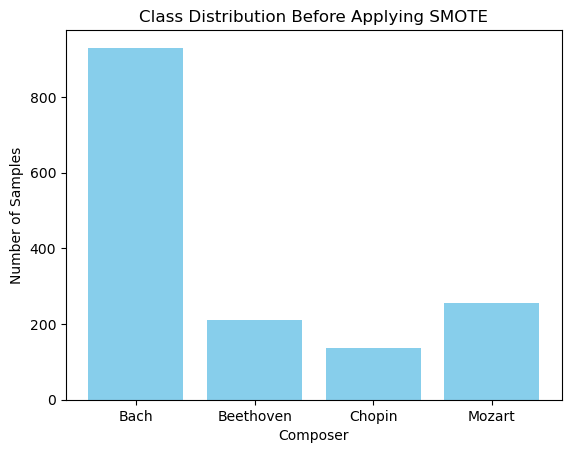

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count the occurrences of each label
unique, counts = np.unique(y, return_counts=True)
label_distribution = dict(zip(unique, counts))

print("Label Distribution:", label_distribution)

plt.bar(label_distribution.keys(), label_distribution.values(), color='skyblue')
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before Applying SMOTE')
plt.show()


Label Distribution After SMOTE: {0: 930, 1: 930, 2: 930, 3: 930}


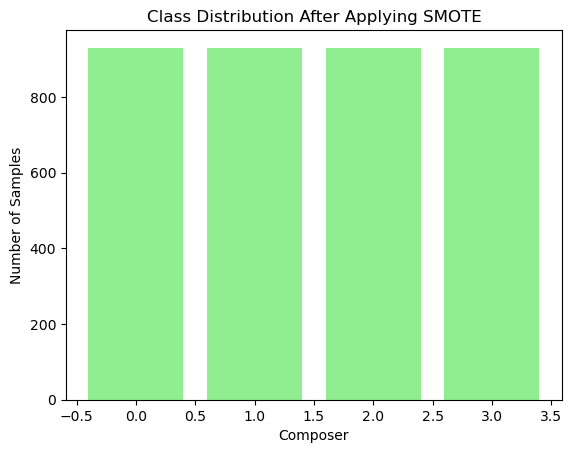

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Apply SMOTE to balance the classes (using the existing encoded labels)
smote = SMOTE(sampling_strategy={1: 930, 2: 930, 3: 930}, random_state=42)  #  1, 2, 3 are Beethoven, Chopin, Mozart
X_smote, y_smote = smote.fit_resample(X_scaled, y_encoded)

unique_smote, counts_smote = np.unique(y_smote, return_counts=True)
label_distribution_smote = dict(zip(unique_smote, counts_smote))

print("Label Distribution After SMOTE:", label_distribution_smote)

plt.bar(label_distribution_smote.keys(), label_distribution_smote.values(), color='lightgreen')
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Applying SMOTE')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Split the SMOTE-augmented data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Val set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (2232, 4)
Validation set shape: (744, 4)
Test set shape: (744, 4)


In [ ]:
time_steps = 1
n_features = X_train.shape[1]

X_train_reshaped = X_train.reshape((X_train.shape[0], time_steps, n_features))
X_val_reshaped = X_val.reshape((X_val.shape[0], time_steps, n_features))
X_test_reshaped = X_test.reshape((X_test.shape[0], time_steps, n_features))

print(f"Reshaped Training set shape: {X_train_reshaped.shape}")
print(f"Reshaped Validation set shape: {X_val_reshaped.shape}")
print(f"Reshaped Test set shape: {X_test_reshaped.shape}")


Reshaped Training set shape: (2232, 1, 4)
Reshaped Validation set shape: (744, 1, 4)
Reshaped Test set shape: (744, 1, 4)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, LSTM, Dense, Dropout, BatchNormalization

# Build the CNN-LSTM model
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(time_steps, n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Reshape((time_steps, -1)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  # 4 classes for composers

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val), batch_size=32)

test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
70/70 [==============================] - 2s 7ms/step - loss: 1.2659 - accuracy: 0.4400 - val_loss: 1.2181 - val_accuracy: 0.4812
Epoch 2/20
70/70 [==============================] - 0s 2ms/step - loss: 1.0785 - accuracy: 0.5336 - val_loss: 1.0815 - val_accuracy: 0.5753
Epoch 3/20
70/70 [==============================] - 0s 2ms/step - loss: 1.0202 - accuracy: 0.5426 - val_loss: 1.0302 - val_accuracy: 0.5874
Epoch 4/20
70/70 [==============================] - 0s 2ms/step - loss: 0.9990 - accuracy: 0.5609 - val_loss: 0.9686 - val_accuracy: 0.5847
Epoch 5/20
70/70 [==============================] - 0s 2ms/step - loss: 1.0022 - accuracy: 0.5753 - val_loss: 0.9479 - val_accuracy: 0.5927
Epoch 6/20
70/70 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5708 - val_loss: 0.9310 - val_accuracy: 0.5941
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.9681 - accuracy: 0.5685 - val_loss: 0.9150 - val_accuracy: 0.5860
Epoch 8/20
70/70 [==

 1/24 [>.............................] - ETA: 0s

24/24 [==============================] - 0s 726us/step
Test Accuracy: 0.5914
Test Precision: 0.6083
Test Recall: 0.5914

Classification Report:
              precision    recall  f1-score   support

        Bach       0.76      0.53      0.63       206
   Beethoven       0.53      0.60      0.56       172
      Chopin       0.60      0.67      0.63       190
      Mozart       0.52      0.57      0.54       176

    accuracy                           0.59       744
   macro avg       0.60      0.59      0.59       744
weighted avg       0.61      0.59      0.59       744



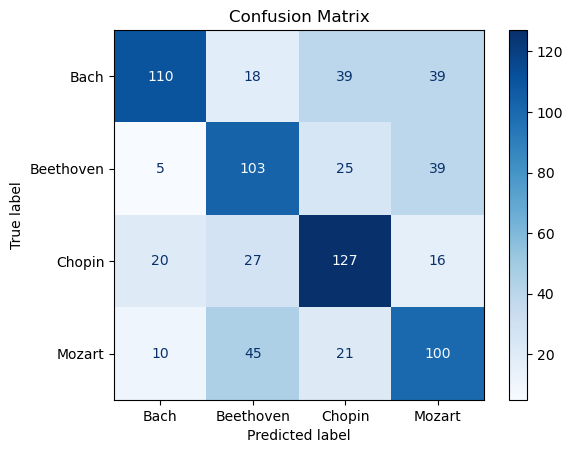

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

y_pred = model.predict(X_test_reshaped)
y_pred_classes = y_pred.argmax(axis=1)

# Accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



The results indicate that while SMOTE has helped to balance the classes and improve performance, the model still struggles with certain composers, especially when distinguishing between "Bach" and "Mozart" or "Beethoven" and "Chopin." The confusion between these classes suggests that the features extracted may not be distinct enough for the model to make clear distinctions, or the model architecture might need further tuning to better capture the differences between these composers.

Further steps could include experimenting with different model architectures, improving feature extraction, or applying more sophisticated data augmentation techniques to improve the model's performance.